<a href="https://colab.research.google.com/github/VictorBenoiston/policy_aspects_key_concepts_retriever/blob/main/key_ceoncepts_extractor_model_for_llm_fowarding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [186]:
import pandas as pd
import warnings
import tensorflow_hub as hub
from sklearn.manifold import TSNE
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
import tensorflow as tf
from keras import layers
from sklearn.metrics import confusion_matrix, f1_score, ConfusionMatrixDisplay, accuracy_score
from itertools import product


In [62]:
df = pd.read_csv("data_set_ids_llm.csv", delimiter=',', header=None, skiprows=1, names=['text', 'category'])

# df = df[['text', 'category']]


In [63]:
df.describe(include='all')

,text,category
count,252,252
unique,252,15
top,in compliance with general and specific regula...,governing law
freq,1,26


In [64]:
df.head()

,text,category
0,in compliance with general and specific regula...,data protection law
1,allowing personal data to be used with the hel...,data protection law
2,With its definition of personal data the GDPR ...,data protection law
3,Anonymization of personal data can enable a da...,data protection law
4,Please note that pseudonymization of personal ...,data protection law


In [67]:
# Avoiding unwanted warnings.
warnings.filterwarnings('ignore')

In [71]:
# Using google's universal sentence encoder (USE) to retrieve embedded semantic value
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [73]:
text_vect = embed(df['text'])
x_reduced = TSNE(n_components=2, random_state=0).fit_transform(text_vect)

In [74]:
pd.merge(
    left = pd.concat([pd.DataFrame(x_reduced),df['category']],axis = 1),
    right = pd.DataFrame(df['category'].value_counts()).reset_index().rename(columns={"index":"category", "category":"count"}),
    on='category', how='left')

,0,1,category,count
0,0.979996,16.350788,data protection law,19
1,4.968322,-6.691977,data protection law,19
2,-4.599285,0.928789,data protection law,19
3,4.120081,-5.797650,data protection law,19
4,3.528888,-6.030994,data protection law,19
...,...,...,...,...
247,-8.492976,8.628730,usge control,17
248,0.441877,1.034583,usge control,17
249,0.899316,7.192078,usge control,17
250,12.819413,-11.456576,usge control,17


in compliance with general and specific regulations ranging from anti-trust to GDPR and cyber-security regulations as well as sector specific regulations.allowing personal data to be used with the help of a personal data sharing intermediary that safeguards data subjects’ rights under the GDPR;With its definition of personal data the GDPR has determined an ample scope: “personal data means any information relating to an identified or identifiable natural person; an identifiable natural person is one who can be identified directly or indirectly in particular by reference to an identifier such as a name an identification number location data on online identifier or to one or more factors specific to the physical physiological genetic mental economic cultural or social identity of that natural person.”Anonymization of personal data can enable a data controller to further process the data without considering the data protection requirements provided that the data is no longer related to a

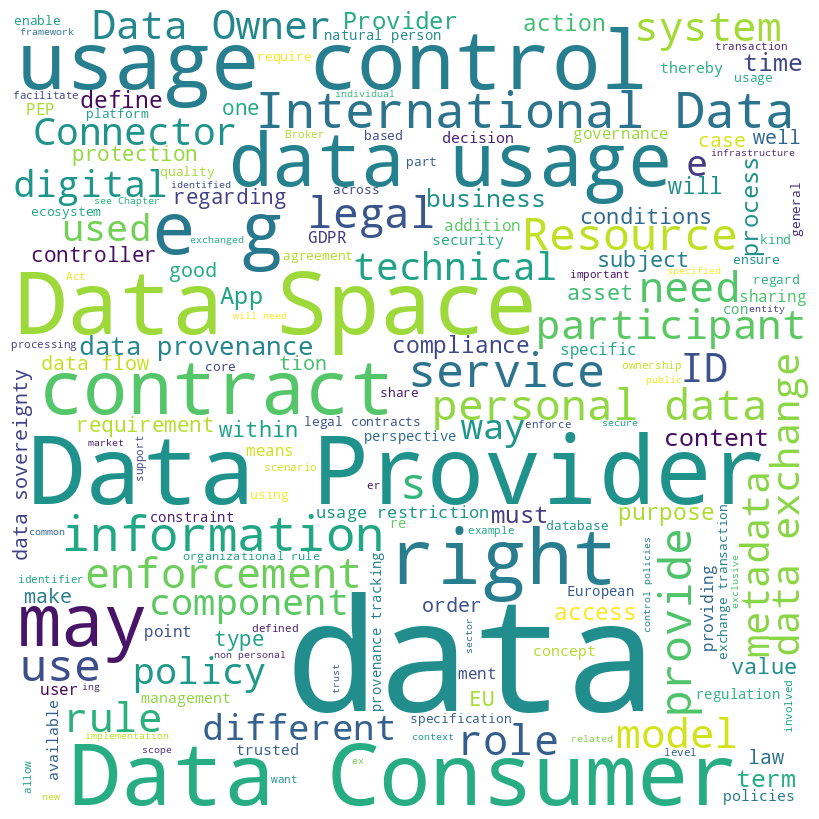

In [88]:
#Generating Word Coud

# text = df.text

text = ''

for item in df.text:
  text += "".join(item) + ""

print(text)


stopWords = set(STOPWORDS)


wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopWords,
                min_font_size = 10).generate(text)

# plot the WordCloud image
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

In [169]:
sentences = df["text"].apply(lambda x: x.lower()).tolist()
# generating training data matrix
embed_matrix = []
for sent in sentences:
    embed_matrix.append(np.array(embed([sent])[0]).tolist())

In [179]:
# df[['text', 'category']].iloc[150]

In [190]:
# Transforming catagories label
lb = LabelBinarizer().fit(list(set(df['category'].tolist())))

In [196]:
# Splitting the dataset into train, test and validation.

X, Y = np.array(embed_matrix), lb.transform(df['category'].tolist())

x_train, x_temp, y_train, y_temp = train_test_split(X, Y, test_size=0.3, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

In [192]:
# In order to avoid overfitting, I added an early stop.

es_callback = keras.callbacks.EarlyStopping(monitor='val_loss')

In [204]:
x_train.shape

(176, 512)

In [207]:
input_dim = 512

learning_rates = [0.001, 0.004, 0.007, 0.0001]
unit_values = [10, 30, 50, 70, 100]
epoch_values = [20, 50, 100, 130]
dropout_values = [0.2, 0.3, 0.4]

# Creating all possible combinations of hyperparameters
hyperparameter_combinations = list(product(learning_rates, unit_values, epoch_values, dropout_values))

# Dictionary to store training results for each combination
all_results = {}

# Training the models for each possible combination
for learning_rate, units_value, epochs_value, dropout_value in hyperparameter_combinations:

  # Model Architecture
  ann = tf.keras.models.Sequential()
  ann.add(tf.keras.Input(shape=input_dim))
  ann.add(tf.keras.layers.Dense(units=units_value, activation='relu'))
  ann.add(tf.keras.layers.Dropout(dropout_value))
  ann.add(tf.keras.layers.Dense(units=15, activation='softmax'))

  # Compiling the model
  optimizer = tf.keras.optimizers.Adam (learning_rate=learning_rate)
  ann.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

  # Training the model
  history = ann.fit(x_train, y_train, epochs=epochs_value, batch_size=10, validation_split=0.3)

  # Storing the metrics of each model
  final_train_loss = history.history['loss'][-1]
  final_train_accuracy = history.history['accuracy'][-1]
  final_val_loss = history.history['val_loss'][-1]
  final_val_accuracy = history.history['val_accuracy'][-1]

  # Storing the metrics per model in the dictionary
  model_key = f"LR_{learning_rate}_Units_{units_value}_Epochs_{epochs_value}_Dropout_{dropout_value}"
  all_results[model_key] = {
      'learning_rate': learning_rate,
      'units': units_value,
      'epochs': epochs_value,
      'dropout': dropout_value,
      'final_train_loss': final_train_loss,
      'final_train_accuracy': final_train_accuracy,
      'final_val_loss': final_val_loss,
      'final_val_accuracy': final_val_accuracy
  }


Streaming output truncated to the last 5000 lines.
13/13 [==============================] - 0s 7ms/step - loss: 2.5074 - accuracy: 0.4797 - val_loss: 2.6629 - val_accuracy: 0.1509
Epoch 42/50
13/13 [==============================] - 0s 7ms/step - loss: 2.5144 - accuracy: 0.4715 - val_loss: 2.6617 - val_accuracy: 0.1698
Epoch 43/50
13/13 [==============================] - 0s 8ms/step - loss: 2.5052 - accuracy: 0.4228 - val_loss: 2.6599 - val_accuracy: 0.1698
Epoch 44/50
13/13 [==============================] - 0s 7ms/step - loss: 2.5049 - accuracy: 0.4309 - val_loss: 2.6586 - val_accuracy: 0.1321
Epoch 45/50
13/13 [==============================] - 0s 7ms/step - loss: 2.4936 - accuracy: 0.5041 - val_loss: 2.6567 - val_accuracy: 0.1321
Epoch 46/50
13/13 [==============================] - 0s 7ms/step - loss: 2.4947 - accuracy: 0.4553 - val_loss: 2.6552 - val_accuracy: 0.1321
Epoch 47/50
13/13 [==============================] - 0s 7ms/step - loss: 2.4874 - accuracy: 0.4390 - val_loss: 2.65

In [208]:
# Showing all the models parameters for analysis.

for k, va in all_results.items():
  print(f'Architecture {k} parameters: ')
  for k, v in va.items():
    print(f'{k}: {v:.6f}')
  print('-------------------------------------------')

Architecture LR_0.001_Units_10_Epochs_20_Dropout_0.2 parameters: 
learning_rate: 0.001000
units: 10.000000
epochs: 20.000000
dropout: 0.200000
final_train_loss: 2.322191
final_train_accuracy: 0.268293
final_val_loss: 2.608979
final_val_accuracy: 0.150943
-------------------------------------------
Architecture LR_0.001_Units_10_Epochs_20_Dropout_0.3 parameters: 
learning_rate: 0.001000
units: 10.000000
epochs: 20.000000
dropout: 0.300000
final_train_loss: 2.332435
final_train_accuracy: 0.243902
final_val_loss: 2.563166
final_val_accuracy: 0.075472
-------------------------------------------
Architecture LR_0.001_Units_10_Epochs_20_Dropout_0.4 parameters: 
learning_rate: 0.001000
units: 10.000000
epochs: 20.000000
dropout: 0.400000
final_train_loss: 2.367133
final_train_accuracy: 0.260163
final_val_loss: 2.640039
final_val_accuracy: 0.094340
-------------------------------------------
Architecture LR_0.001_Units_10_Epochs_50_Dropout_0.2 parameters: 
learning_rate: 0.001000
units: 10.000

In [220]:
max_accuracy = 0.0
best_model_key = None

for model_key, results in all_results.items():
    current_accuracy = results['final_val_accuracy']

    if current_accuracy > max_accuracy:
        max_accuracy = current_accuracy
        best_model_key = model_key

print(f"Best Modek: {best_model_key}, Highest Final Validation Accuracy: {max_accuracy:.4f}")

Best Modek: LR_0.007_Units_70_Epochs_100_Dropout_0.4, Highest Final Validation Accuracy: 0.3585


In [225]:
# Training the best model

# Model Architecture
ann = tf.keras.models.Sequential()
ann.add(tf.keras.Input(shape=input_dim))
ann.add(tf.keras.layers.Dense(units=70, activation='relu'))
ann.add(tf.keras.layers.Dropout(0.4))
ann.add(tf.keras.layers.Dense(units=15, activation='softmax'))

# Compiling the model
optimizer = tf.keras.optimizers.Adam (learning_rate=0.007)
ann.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Training the model
history = ann.fit(x_train, y_train, epochs=100, batch_size=10, validation_split=0.3)

Epoch 1/100
13/13 [==============================] - 2s 49ms/step - loss: 2.6904 - accuracy: 0.1057 - val_loss: 2.6410 - val_accuracy: 0.0755
Epoch 2/100
13/13 [==============================] - 0s 17ms/step - loss: 2.4129 - accuracy: 0.2927 - val_loss: 2.5464 - val_accuracy: 0.1887
Epoch 3/100
13/13 [==============================] - 0s 15ms/step - loss: 2.0870 - accuracy: 0.3821 - val_loss: 2.4689 - val_accuracy: 0.2264
Epoch 4/100
13/13 [==============================] - 0s 18ms/step - loss: 1.6761 - accuracy: 0.6179 - val_loss: 2.3109 - val_accuracy: 0.3208
Epoch 5/100
13/13 [==============================] - 0s 16ms/step - loss: 1.4451 - accuracy: 0.6423 - val_loss: 2.2268 - val_accuracy: 0.2642
Epoch 6/100
13/13 [==============================] - 0s 17ms/step - loss: 1.1109 - accuracy: 0.7236 - val_loss: 2.3092 - val_accuracy: 0.2642
Epoch 7/100
13/13 [==============================] - 0s 17ms/step - loss: 0.9056 - accuracy: 0.7724 - val_loss: 2.2021 - val_accuracy: 0.3208
Epoch 

In [226]:
# prediction cell
sorted(list(set(df['category'].tolist())))[ann.predict(embed([df["text"].iloc[170]])).argmax(axis=1)[0]]

1/1 [==============================] - 0s 58ms/step


'service provider'

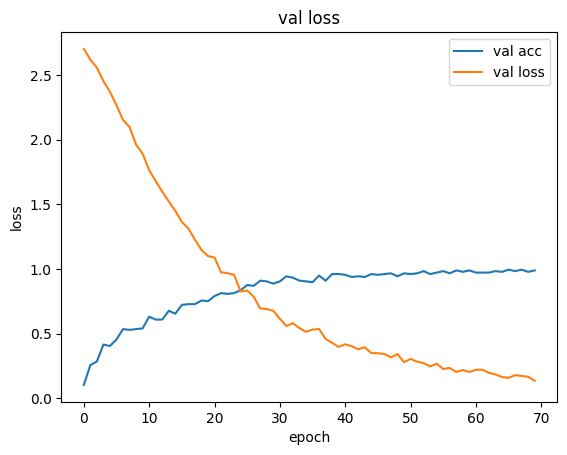

In [148]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.title('val accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('val loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['val acc', 'val loss'], loc='upper right')
plt.show()

2/2 [==============================] - 0s 6ms/step


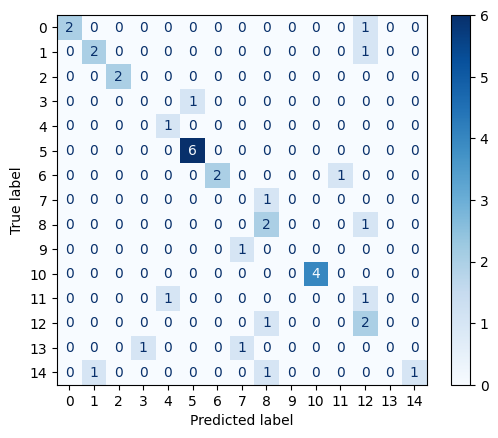

In [149]:
# label encoding for validation purposes
le = LabelEncoder().fit(sorted(list(set(df['category'].tolist()))))

# Confusion Matrix
cm_rm_2 = confusion_matrix(le.transform(lb.inverse_transform(np.array(y_test))),ann.predict(x_test).argmax(axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rm_2)
disp.plot(cmap=plt.cm.Blues)
plt.show()